In [1]:
!nvidia-smi

Thu May  2 10:43:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:41:00.0 Off |                  Off |
| 30%   41C    P2             62W /  230W |     687MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import math
from PIL import Image

/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
preprocess = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    labels = [l for l in examples["label"]]
    return {"images": images, "labels": labels}

Resolving data files:   0%|          | 0/537 [00:00<?, ?it/s]

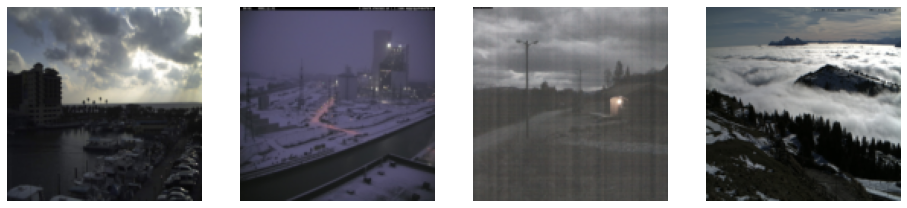

In [4]:
test_dataset = load_dataset("imagefolder", data_dir="transient-attr-images/test", split="train")
test_dataset.set_transform(transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)
test_samples = next(iter(test_dataloader))
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(test_samples["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [5]:


def setup_model(config, train_dataloader):
    from diffusers.optimization import get_cosine_schedule_with_warmup
    from diffusers import UNet2DModel
    from diffusers import DDPMScheduler
    from diffusers import DDIMScheduler
    
    model = UNet2DModel(
        sample_size=config.image_size,  # the target image resolution
        in_channels=3,  # the number of input channels, 3 for RGB images
        out_channels=3,  # the number of output channels
        layers_per_block=2,  # how many ResNet layers to use per UNet block
        block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "DownBlock2D",
            "DownBlock2D",
            "DownBlock2D",
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D"
        ),
        num_class_embeds=5
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=(len(train_dataloader) * config.num_epochs),
    )
    
    noise_scheduler = DDIMScheduler(
        beta_start=0.00085, 
        beta_end=0.012, 
        beta_schedule="scaled_linear", 
        clip_sample=False, 
        set_alpha_to_one=False
    )
    # noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
    return model, optimizer, lr_scheduler, noise_scheduler

torch.cuda.is_initialized()

False

In [6]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

In [7]:
# import glob

# sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
# Image.open(sample_images[-1])

In [40]:
import os
from diffusers.utils import pt_to_pil

def get_pipeline_for_inference(save_path):
    from ddim import CustomDDIMPipeline
    pipeline = CustomDDIMPipeline.from_pretrained(save_path, use_safetensors=True)
    return pipeline

def generate_image_of_class(pipeline, dataloader, fname):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`

    batch = next(iter(dataloader))
    clean_images = batch["images"].to(pipeline._execution_device)
    original_labels = batch["labels"]
    noise = torch.randn(clean_images.shape).to(pipeline._execution_device)
    noisy_images = pipeline.scheduler.add_noise(clean_images, noise, torch.LongTensor([999]))
    class_labels = torch.randint(0, 4, original_labels.shape, device=pipeline._execution_device)
    images = pipeline.style_transfer(
        noisy_images,
        # generator=torch.manual_seed(0),
        class_labels=class_labels
    ).images

    # Make a grid out of the images
    clean_imgs_pil = pt_to_pil(clean_images)
    grid_images = clean_imgs_pil + images
    image_grid = make_grid(grid_images, rows=2, cols=len(clean_imgs_pil))

    # Save the images
    test_dir = os.path.join("style-transferred-samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{fname}.png")
    print("Original labels: ", original_labels)
    print("Style Transferred Labels: ", class_labels)

In [41]:
device = "cuda"
pipeline = get_pipeline_for_inference("ddpm-transient-attrs-128").to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [42]:
generate_image_of_class(pipeline, test_dataloader, "test2")

  0%|          | 0/50 [00:00<?, ?it/s]

Original labels:  tensor([3, 2, 0, 0])
Style Transferred Labels:  tensor([2, 2, 3, 0], device='cuda:0')


In [ ]:
batch = next(iter(test_dataloader))
batch

In [ ]:
clean_images = batch["images"].to(device)
original_labels = batch["labels"]
noise = torch.randn(clean_images.shape).to(device)
noisy_images = pipeline.scheduler.add_noise(clean_images, noise, torch.LongTensor([999]))
class_labels = torch.randint(0, 4, original_labels.shape, device=device)

In [38]:
# set step values
num_inference_steps = 50
eta = 0.0
pipeline.scheduler.set_timesteps(num_inference_steps)

image = noisy_images.clone()
with torch.no_grad():
    for t in pipeline.progress_bar(pipeline.scheduler.timesteps):
        # 1. predict noise model_output
        model_output = pipeline.unet(image, t, class_labels=class_labels).sample
    
        # 2. predict previous mean of image x_t-1 and add variance depending on eta
        # eta corresponds to η in paper and should be between [0, 1]
        # do x_t -> x_t-1
        image = pipeline.scheduler.step(
            model_output, t, image, eta=eta, use_clipped_model_output=None
        ).prev_sample


  0%|          | 0/50 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 23.67 GiB of which 52.56 MiB is free. Process 99369 has 682.00 MiB memory in use. Including non-PyTorch memory, this process has 22.95 GiB memory in use. Of the allocated memory 22.55 GiB is allocated by PyTorch, and 142.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [37]:
from diffusers.utils import pt_to_pil

st_images = pt_to_pil(image)

AttributeError: 'numpy.ndarray' object has no attribute 'clamp'